# Choose where to run

In [1]:
platform = 'jupyter_notebook' #@param ['colab', 'jupyter_notebook'] {allow-input: true}

if platform == 'colab':
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    data_dir = '/content/drive/MyDrive/algonauts_2023_tutorial_data' #@param {type:"string"}
    parent_submission_dir = '/content/drive/MyDrive/algonauts_2023_challenge_submission' #@param {type:"string"}

if platform == 'jupyter_notebook':
    data_dir = './algonauts_2023_challenge_data'
    parent_submission_dir = './algonauts_2023_challenge_submission'

# Import

In [2]:
import os
import tensorflow as tf
import numpy as np
from sklearn.decomposition import IncrementalPCA
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr

2023-02-17 17:13:03.008192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load images

In [3]:
subj_dir = 'subj01'
data_dir = os.path.join(data_dir, subj_dir)
train_img_dir  = os.path.join(data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(data_dir, 'test_split', 'test_images')
train_img_list = os.listdir(train_img_dir)

# Create a dataset

In [4]:
batch_size = 300
split = 0.9
num_batches_train = int(len(train_img_list) * split // batch_size)
num_samples_train = int(num_batches_train * batch_size)

def create_dataset_from_image_paths(image_dir):
    dataset = tf.keras.utils.image_dataset_from_directory(image_dir, image_size=(224, 224), labels=None, shuffle=False, batch_size=batch_size)
    # np.expand_dims(x, axis=0) TODO: they use this in docs, but not sure if it's needed, let's try it out
    dataset = dataset.map(tf.keras.applications.resnet50.preprocess_input) # For Alexnet they use tf.keras.layers.experimental.preprocessing.Normalization(mean=[0.485, 0.456, 0.406], variance=[0.229, 0.224, 0.225])
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

dataset = create_dataset_from_image_paths(train_img_dir)
# create train and validation dataset from the training dataset (90% train, 10% validation)
train_dataset = dataset.take(num_batches_train)
val_dataset = dataset.skip(num_batches_train)

test_dataset = create_dataset_from_image_paths(test_img_dir)

print('Training dataset size: ' + str(len(train_dataset)))
print('Validation dataset size: ' + str(len(val_dataset)))
print('Test dataset size: ' + str(len(test_dataset)))

Found 9841 files belonging to 1 classes.
Found 159 files belonging to 1 classes.
Training dataset size: 29
Validation dataset size: 4
Test dataset size: 1


2023-02-17 17:13:15.378989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Define a model and a readout layer

In [5]:
# Take models from here https://keras.io/api/applications/
base_model = tf.keras.applications.ResNet50(weights='imagenet')
for layer in base_model.layers:
    print(layer.name)

model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_out').output)

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

# PCA

In [6]:
pca = IncrementalPCA(n_components=100, batch_size=batch_size)

# Fit PCA to batch of datastet
for batch in tqdm(train_dataset):
    # Extract features
    features = model.predict(batch)
    # Flatten the features
    features = features.reshape(features.shape[0], -1)
    # Fit PCA to batch of features
    pca.partial_fit(features)

  0%|          | 0/29 [00:00<?, ?it/s]

10/10 [==============================] - 44s 4s/step


  3%|▎         | 1/29 [00:59<27:41, 59.33s/it]

10/10 [==============================] - 34s 3s/step


  7%|▋         | 2/29 [01:56<26:09, 58.13s/it]

10/10 [==============================] - 33s 3s/step


 10%|█         | 3/29 [02:51<24:34, 56.70s/it]

10/10 [==============================] - 44s 4s/step


 14%|█▍        | 4/29 [04:00<25:40, 61.61s/it]

10/10 [==============================] - 41s 4s/step


 17%|█▋        | 5/29 [05:46<30:57, 77.41s/it]

10/10 [==============================] - 44s 4s/step


 21%|██        | 6/29 [06:54<28:27, 74.23s/it]

10/10 [==============================] - 463s 51s/step


 24%|██▍       | 7/29 [23:16<2:16:05, 371.18s/it]

10/10 [==============================] - 66s 6s/step


 28%|██▊       | 8/29 [24:48<1:38:44, 282.11s/it]

10/10 [==============================] - 35s 3s/step


 31%|███       | 9/29 [25:43<1:10:21, 211.08s/it]

10/10 [==============================] - 32s 3s/step


 34%|███▍      | 10/29 [26:35<51:19, 162.10s/it] 

10/10 [==============================] - 45s 5s/step


 38%|███▊      | 11/29 [27:42<39:54, 133.03s/it]

10/10 [==============================] - 34s 3s/step


 41%|████▏     | 12/29 [28:38<31:00, 109.46s/it]

10/10 [==============================] - 34s 3s/step


 45%|████▍     | 13/29 [29:31<24:40, 92.54s/it] 

10/10 [==============================] - 32s 3s/step


 48%|████▊     | 14/29 [30:23<20:01, 80.10s/it]

10/10 [==============================] - 31s 3s/step


 52%|█████▏    | 15/29 [31:14<16:41, 71.51s/it]

10/10 [==============================] - 31s 3s/step


 55%|█████▌    | 16/29 [32:05<14:09, 65.37s/it]

10/10 [==============================] - 31s 3s/step


 59%|█████▊    | 17/29 [32:57<12:14, 61.18s/it]

10/10 [==============================] - 31s 3s/step


 62%|██████▏   | 18/29 [33:48<10:40, 58.20s/it]

10/10 [==============================] - 31s 3s/step


 66%|██████▌   | 19/29 [34:40<09:21, 56.19s/it]

10/10 [==============================] - 31s 3s/step


 69%|██████▉   | 20/29 [35:30<08:10, 54.54s/it]

10/10 [==============================] - 31s 3s/step


 72%|███████▏  | 21/29 [36:21<07:08, 53.52s/it]

10/10 [==============================] - 31s 3s/step


 76%|███████▌  | 22/29 [37:12<06:08, 52.66s/it]

10/10 [==============================] - 31s 3s/step


 79%|███████▉  | 23/29 [38:02<05:11, 51.96s/it]

10/10 [==============================] - 31s 3s/step


 83%|████████▎ | 24/29 [38:57<04:23, 52.76s/it]

10/10 [==============================] - 31s 3s/step


 86%|████████▌ | 25/29 [39:58<03:41, 55.34s/it]

10/10 [==============================] - 30s 3s/step


 90%|████████▉ | 26/29 [41:01<02:52, 57.43s/it]

10/10 [==============================] - 45s 5s/step


 93%|█████████▎| 27/29 [42:11<02:02, 61.23s/it]

10/10 [==============================] - 49s 5s/step


 97%|█████████▋| 28/29 [43:28<01:05, 65.99s/it]

10/10 [==============================] - 41s 4s/step


100%|██████████| 29/29 [44:33<00:00, 92.20s/it]


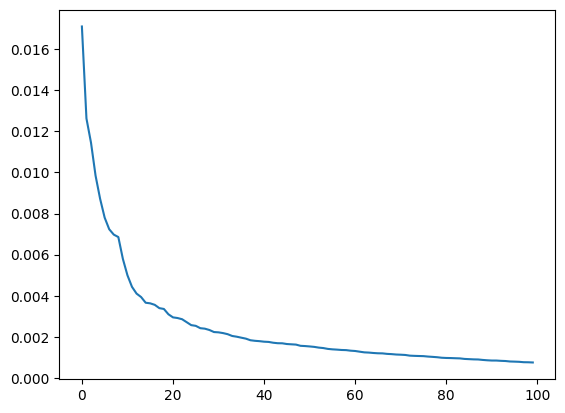

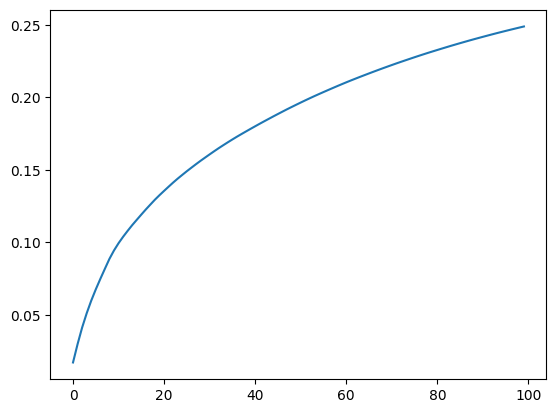

In [7]:
# plot the explained variance
plt.plot(pca.explained_variance_ratio_)
plt.show()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [8]:
def extract_features(dataset, model, pca):
    features = []
    for batch in tqdm(dataset):
        ft = model.predict(batch)
        # Flatten the features
        ft = ft.reshape(ft.shape[0], -1)
        # Fit PCA to batch of features
        ft = pca.transform(ft)
        features.append(ft)
    return np.vstack(features) # why do we need to stack the features? will .extend() work?


In [9]:
features_train = extract_features(train_dataset, model, pca)
features_val = extract_features(val_dataset, model, pca)
features_test = extract_features(test_dataset, model, pca)

  0%|          | 0/29 [00:00<?, ?it/s]

10/10 [==============================] - 53s 5s/step


  3%|▎         | 1/29 [01:02<29:08, 62.43s/it]

10/10 [==============================] - 39s 4s/step


  7%|▋         | 2/29 [01:42<22:08, 49.19s/it]

10/10 [==============================] - 35s 3s/step


 10%|█         | 3/29 [02:19<18:50, 43.48s/it]

10/10 [==============================] - 36s 3s/step


 14%|█▍        | 4/29 [02:55<17:00, 40.83s/it]

10/10 [==============================] - 38s 4s/step


 17%|█▋        | 5/29 [03:34<16:03, 40.15s/it]

10/10 [==============================] - 41s 4s/step


 21%|██        | 6/29 [04:17<15:44, 41.09s/it]

10/10 [==============================] - 39s 4s/step


 24%|██▍       | 7/29 [04:57<14:56, 40.76s/it]

10/10 [==============================] - 38s 4s/step


 28%|██▊       | 8/29 [05:39<14:24, 41.15s/it]

10/10 [==============================] - 31s 3s/step


 31%|███       | 9/29 [06:11<12:42, 38.14s/it]

10/10 [==============================] - 32s 3s/step


 34%|███▍      | 10/29 [06:44<11:38, 36.75s/it]

10/10 [==============================] - 47s 5s/step


 38%|███▊      | 11/29 [07:34<12:12, 40.69s/it]

10/10 [==============================] - 38s 3s/step


 41%|████▏     | 12/29 [08:13<11:23, 40.21s/it]

10/10 [==============================] - 43s 4s/step


 45%|████▍     | 13/29 [08:58<11:06, 41.63s/it]

10/10 [==============================] - 39s 4s/step


 48%|████▊     | 14/29 [09:38<10:15, 41.07s/it]

10/10 [==============================] - 40s 4s/step


 52%|█████▏    | 15/29 [10:19<09:36, 41.18s/it]

10/10 [==============================] - 36s 4s/step


 55%|█████▌    | 16/29 [10:56<08:38, 39.88s/it]

10/10 [==============================] - 34s 3s/step


 59%|█████▊    | 17/29 [11:31<07:40, 38.34s/it]

10/10 [==============================] - 36s 3s/step


 62%|██████▏   | 18/29 [12:08<06:58, 38.08s/it]

10/10 [==============================] - 34s 3s/step


 66%|██████▌   | 19/29 [12:43<06:11, 37.15s/it]

10/10 [==============================] - 31s 3s/step


 69%|██████▉   | 20/29 [13:16<05:21, 35.68s/it]

10/10 [==============================] - 41s 4s/step


 72%|███████▏  | 21/29 [13:58<05:01, 37.70s/it]

10/10 [==============================] - 34s 3s/step


 76%|███████▌  | 22/29 [14:33<04:19, 37.02s/it]

10/10 [==============================] - 33s 3s/step


 79%|███████▉  | 23/29 [15:07<03:35, 35.88s/it]

10/10 [==============================] - 30s 3s/step


 83%|████████▎ | 24/29 [15:38<02:52, 34.47s/it]

10/10 [==============================] - 31s 3s/step


 86%|████████▌ | 25/29 [16:10<02:15, 33.76s/it]

10/10 [==============================] - 30s 3s/step


 90%|████████▉ | 26/29 [16:41<01:38, 32.95s/it]

10/10 [==============================] - 29s 3s/step


 93%|█████████▎| 27/29 [17:11<01:03, 31.94s/it]

10/10 [==============================] - 30s 3s/step


 97%|█████████▋| 28/29 [17:41<00:31, 31.57s/it]

10/10 [==============================] - 29s 3s/step


  0%|          | 0/4 [00:00<?, ?it/s]

10/10 [==============================] - 35s 3s/step


 25%|██▌       | 1/4 [01:27<04:23, 87.89s/it]

10/10 [==============================] - 35s 3s/step


 50%|█████     | 2/4 [02:03<01:54, 57.24s/it]

10/10 [==============================] - 30s 3s/step


 75%|███████▌  | 3/4 [02:34<00:45, 45.14s/it]

8/8 [==============================] - 28s 4s/step


  0%|          | 0/1 [00:00<?, ?it/s]

5/5 [==============================] - 18s 4s/step


100%|██████████| 1/1 [00:19<00:00, 19.49s/it]


In [10]:
del model, pca

# Handle frmi files

In [11]:
fmri_dir = os.path.join(data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')

LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)


In [12]:
lh_fmri_train = lh_fmri[:num_samples_train]
lh_fmri_val = lh_fmri[num_samples_train:]
rh_fmri_train = rh_fmri[:num_samples_train]
rh_fmri_val = rh_fmri[num_samples_train:]

In [13]:
del lh_fmri, rh_fmri

# Fitting regression

In [14]:
reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_val_pred = reg_lh.predict(features_val)
lh_fmri_test_pred = reg_lh.predict(features_test)
rh_fmri_val_pred = reg_rh.predict(features_val)
rh_fmri_test_pred = reg_rh.predict(features_test)

# Calculating correlation

In [15]:
# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_val_pred.shape[1])):
    lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]

# Empty correlation array of shape: (RH vertices)
rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_val_pred.shape[1])):
    rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]

100%|██████████| 20544/20544 [00:04<00:00, 4151.06it/s]


# Visualize

/opt/miniconda3/envs/algonauts/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/algonauts/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


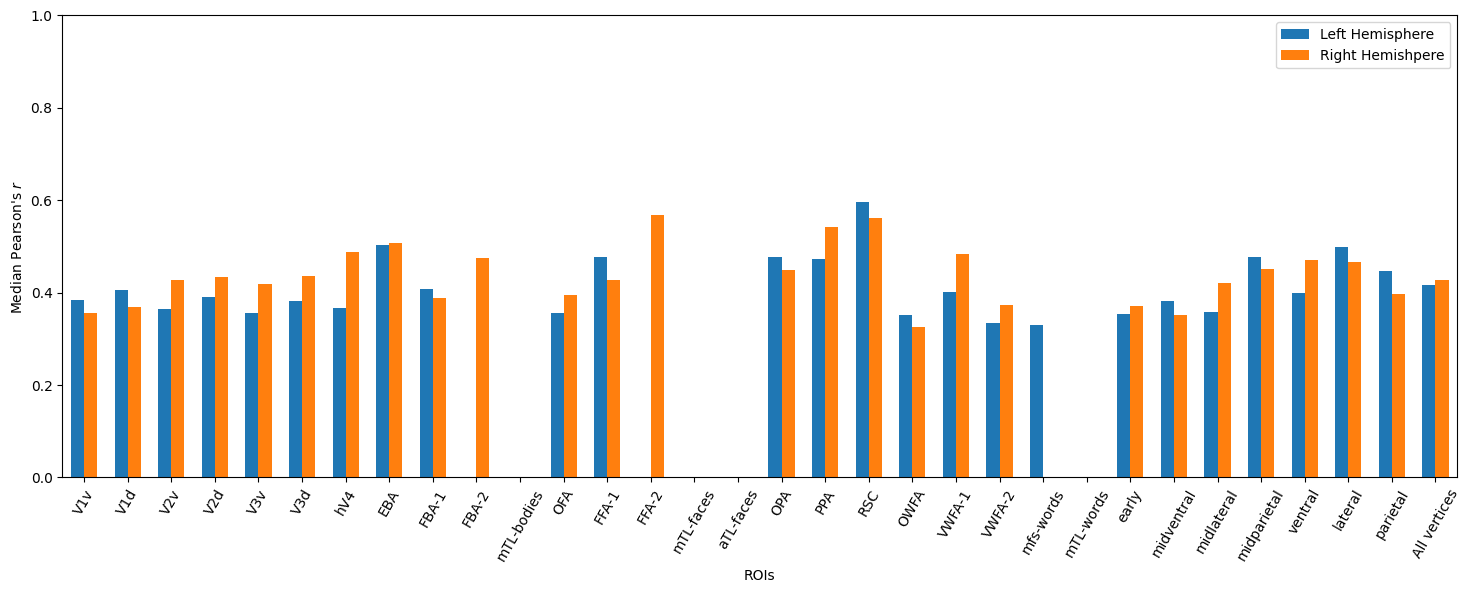

In [16]:
# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
            lh_roi_correlation.append(lh_correlation[lh_roi_idx])
            rh_roi_correlation.append(rh_correlation[rh_roi_idx])
roi_names.append('All vertices')
lh_roi_correlation.append(lh_correlation)
rh_roi_correlation.append(rh_correlation)

# Create the plot
lh_median_roi_correlation = [np.median(lh_roi_correlation[r])
    for r in range(len(lh_roi_correlation))]
rh_median_roi_correlation = [np.median(rh_roi_correlation[r])
    for r in range(len(rh_roi_correlation))]
plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation, width,
    label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1)